In [78]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [79]:
from elasticsearch import Elasticsearch, helpers, AsyncElasticsearch
import numpy as np
import glob
import json
import copy

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [81]:
def check_ctx_len(data_list: list):
    prag_list = [] # 길이 정보만 
    check_docs = []

    for doc in data_list:
        form = {
        "title":"",
        "len_pragraphs":0,
        "len_ctxs": 0,
        "len_qas": 0,
        "context":""
        }
        try:
            form["title"] = doc['title']
        except:
            form["title"] = doc['doc_title']
        form['len_pragraphs'] = len(doc['paragraphs'])
        for prag in doc['paragraphs']:
            form["len_ctxs"] = len(prag['context'].split(" "))
            form["context"] = prag['context']
            form["len_qas"] = len(prag["qas"])
        prag_list.append(form)
    return prag_list
    

In [82]:
def show_doc_len(res_list, func):
    for r in res_list:
        res = check_ctx_len(r)# 최대 최소 등 길이 정보를 조회하는 목적
        idx = -1
        len_list = [l["len_ctxs"] for l in res]
        print(func(len_list))
        arr = np.array(len_list)
        try:
            idx = len_list.index(func(len_list))
        except:
            pass

In [83]:
def index_mrc_docs(idx: str, docs: dict, title: str = 'title', doc_id: str = None) -> list:
    # title 키값 이름이 다달라서 파라메터로 받음
    docs_insert = []
    index = idx
    for k, v in docs.items():
        src = f"{index}_{k}"
                
        for d in v['data']:
            r_tmp = {}
            if doc_id:
                r_tmp["doc_id"] = d[doc_id]
            for single_prag in d["paragraphs"]:
                tmp = copy.deepcopy(r_tmp)
                tmp["_index"] = index
                tmp["source"] = src
                tmp["title"] = d[title]
                tmp.update(single_prag)
                docs_insert.append(tmp)
    return docs_insert

In [84]:
def load_dataset(path_list: list, train: str = 'train') :
    # train 데이터 파일 이름에 train이 없을때를 대비하려고 파라메터로 받음
    docs = {}
    for doc in path_list:
        with open( doc, "r",encoding='utf8') as fr:
            if train in doc:
                docs['train'] = json.load(fr)
            else:
                docs['dev'] = json.load(fr)
    return docs

In [85]:
es_config = glob.glob("/home/hjb/workspace/DPR/es_idx_config/mrc/*")
print(es_config)

['/home/hjb/workspace/DPR/es_idx_config/mrc/mrc_mapping.json', '/home/hjb/workspace/DPR/es_idx_config/mrc/setting.json']


# Create Index

In [86]:
payload = {}

for config_ in es_config:
    with open(config_, 'r', encoding='utf8') as fr:
        if 'mapping' in config_:
            payload.update(json.load(fr))
        else:
            payload.update(json.load(fr))

In [87]:
es = Elasticsearch(["http://localhost:9200"])


In [88]:
payload["mappings"]

{'properties': {'origin_id': {'type': 'keyword', 'index': False},
  'offset': {'type': 'keyword', 'index': False},
  'title': {'type': 'text',
   'fields': {'nori': {'type': 'text', 'analyzer': 'uni_nori_analyzer'},
    'keyword': {'type': 'keyword', 'normalizer': 'default_normalizer'}},
   'similarity': 'my_sim'},
  'context': {'type': 'text',
   'fields': {'ngram': {'type': 'text', 'analyzer': 'ngram_analyzer'},
    'nori': {'type': 'text', 'analyzer': 'nori_analyzer'},
    'keyword': {'type': 'keyword', 'normalizer': 'default_normalizer'}},
   'similarity': 'my_sim'},
  'qas': {'type': 'object', 'enabled': False},
  'source': {'type': 'keyword', 'index': False}}}

In [89]:
es.info()

ObjectApiResponse({'name': 'e9536fb1b1a5', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'FAWHVAD6QMO9equB10N1SQ', 'version': {'number': '8.0.1', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '801d9ccc7c2ee0f2cb121bbe22ab5af77a902372', 'build_date': '2022-02-24T13:55:40.601285296Z', 'build_snapshot': False, 'lucene_version': '9.0.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

In [90]:
indices=["admin_mrc","book_mrc", "news_mrc", "minds_news_mrc", "korquad1"]


In [91]:
for index in indices:
    try:
        es.indices.delete(index=index)
        es.indices.create(index=index ,body=payload)
    except Exception:
        pass

In [92]:
res = es.cat.indices(format="json", v=True)
for r in res: 
    print(r)

{'health': 'yellow', 'status': 'open', 'index': 'minds_news_mrc', 'uuid': 'aeapZJYXS-yhkaKRjgT8cQ', 'pri': '2', 'rep': '1', 'docs.count': '0', 'docs.deleted': '0', 'store.size': '450b', 'pri.store.size': '450b'}
{'health': 'yellow', 'status': 'open', 'index': 'korquad1', 'uuid': 'CCBA7mpORwOuC--Sq7G4fA', 'pri': '2', 'rep': '1', 'docs.count': '0', 'docs.deleted': '0', 'store.size': '450b', 'pri.store.size': '450b'}
{'health': 'yellow', 'status': 'open', 'index': 'book_mrc', 'uuid': 'MrZCzIImTMe1rCDJSGuRsg', 'pri': '2', 'rep': '1', 'docs.count': '0', 'docs.deleted': '0', 'store.size': '450b', 'pri.store.size': '450b'}
{'health': 'yellow', 'status': 'open', 'index': 'news_mrc', 'uuid': 'fYFuBOrdRvCsURR8qxea5w', 'pri': '2', 'rep': '1', 'docs.count': '0', 'docs.deleted': '0', 'store.size': '450b', 'pri.store.size': '450b'}
{'health': 'yellow', 'status': 'open', 'index': 'admin_mrc', 'uuid': '430pATrXQTmOHQ5T7gCs4A', 'pri': '2', 'rep': '1', 'docs.count': '0', 'docs.deleted': '0', 'store.size

# Korquad Indexing

In [93]:
kor_list = glob.glob("./raw_korquad/*.json")

In [94]:
kor_list

['./raw_korquad/KorQuAD_v1.0_train.json',
 './raw_korquad/KorQuAD_v1.0_dev.json']

In [95]:
docs = load_dataset(kor_list)

In [96]:
#docs['train']['data'][0]

In [97]:
print("** mean **")
data_list = [docs['train']['data'], docs['dev']['data']]
show_doc_len(data_list, np.mean)
print("** median **")
show_doc_len(data_list, np.median)
print("** max **")
show_doc_len(data_list, max)

** mean **
109.99718309859155
114.7
** median **
100.0
100.0
** max **
482
523


In [98]:
res = check_ctx_len(docs['train']['data']+docs['dev']['data'])# 최대 최소 등 길이 정보를 조회하는 목적
len_list = [l["len_ctxs"] for l in res]

num = 0

for l in len_list:
    if l > 160:
        num += 1

print(num/len(len_list))

0.0782051282051282


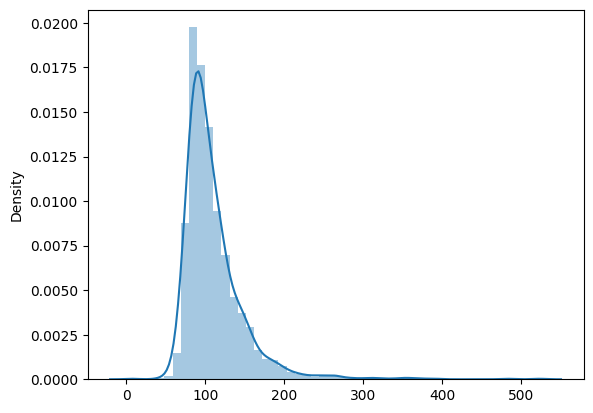

In [99]:
sns.distplot(np.array(len_list))
plt.show()

## korquad 1.0 최대 단락 길이

523

In [100]:
insert_docs = index_mrc_docs(idx='korquad1', docs=docs, title='title')
print(len(insert_docs))

10645


In [101]:
insert_docs[2]

{'_index': 'korquad1',
 'source': 'korquad1_train',
 'title': '파우스트_서곡',
 'qas': [{'answers': [{'text': '주제, 동기', 'answer_start': 70}],
   'id': '6566495-2-0',
   'question': '서주에는 무엇이 암시되어 있는가?'},
  {'answers': [{'text': '제1바이올린', 'answer_start': 148}],
   'id': '6566495-2-1',
   'question': '첫부분에는 어떤 악기를 사용해 더욱 명확하게 나타내는가?'},
  {'answers': [{'text': '소나타 형식', 'answer_start': 272}],
   'id': '6566495-2-2',
   'question': '주요부는 어떤 형식으로 되어 있는가?'},
  {'answers': [{'text': '저음 주제', 'answer_start': 102}],
   'id': '6566518-2-0',
   'question': '첫 부분의 주요주제를 암시하는 주제는?'},
  {'answers': [{'text': 'D장조', 'answer_start': 409}],
   'id': '6566518-2-1',
   'question': '제2주제의 축소된 재현부의 조성은?'},
  {'answers': [{'text': '4/4박자', 'answer_start': 35}],
   'id': '5917067-2-0',
   'question': '곡이 시작할때의 박자는?'},
  {'answers': [{'text': '고뇌와 갈망 동기, 청춘의 사랑 동기', 'answer_start': 115}],
   'id': '5917067-2-1',
   'question': '이 곡의 주요 주제는?'},
  {'answers': [{'text': 'D장조', 'answer_start': 409}],
   'id': '5917067-

In [102]:
helpers.bulk(es, insert_docs)

(10645, [])

# AIHUB data
## admin_mrc

In [103]:
aihub_list = glob.glob("./aihub/admin_mrc/**/*span*.json")


In [104]:
aihub_list

['./aihub/admin_mrc/train/TL_span_extraction_how.json',
 './aihub/admin_mrc/train/TL_span_extraction.json',
 './aihub/admin_mrc/dev/VL_span_extraction_how.json',
 './aihub/admin_mrc/dev/VL_span_extraction.json']

In [105]:
docs = load_dataset(aihub_list, 'TL')

In [106]:
docs['train']['data'][0].keys()

dict_keys(['doc_id', 'doc_title', 'doc_source', 'doc_published', 'doc_class', 'created', 'paragraphs'])

In [107]:
print("** mean **")
data_list = [docs['train']['data'], docs['dev']['data']]
show_doc_len(data_list, np.mean)
print("** median **")
show_doc_len(data_list, np.median)
print("** max **")
show_doc_len(data_list, max)

** mean **
125.46296064568604
128.36695869837297
** median **
121.0
123.0
** max **
431
378


In [108]:
res = check_ctx_len(docs['train']['data']+docs['dev']['data'])# 최대 최소 등 길이 정보를 조회하는 목적
len_list = [l["len_ctxs"] for l in res]

num = 0

for l in len_list:
    if l > 160:
        num += 1

print(num/len(len_list))

0.19664897190352623


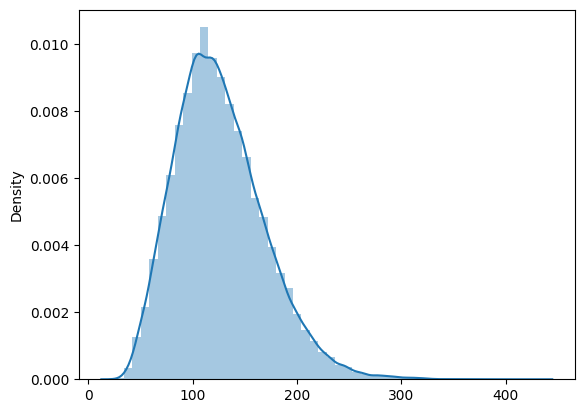

In [109]:
sns.distplot(np.array(len_list))
plt.show()

In [110]:
insert_docs = index_mrc_docs(idx='admin_mrc', docs=docs, title='doc_title', doc_id='doc_id')

In [111]:
helpers.bulk(es, insert_docs)

(75917, [])

## news_mrc

In [112]:
aihub_list = glob.glob("./aihub/news_mrc/**/*extract*.json")

In [113]:
aihub_list

['./aihub/news_mrc/train/TL_span_extraction.json',
 './aihub/news_mrc/dev/VL_span_extraction.json']

In [114]:
docs = load_dataset(aihub_list, 'train')

In [115]:
docs['train']['data'][0].keys()

dict_keys(['doc_id', 'doc_title', 'doc_source', 'doc_published', 'doc_class', 'created', 'paragraphs'])

In [116]:
print("** mean **")
data_list = [docs['train']['data'], docs['dev']['data']]
show_doc_len(data_list, np.mean)
print("** median **")
show_doc_len(data_list, np.median)
print("** max **")
show_doc_len(data_list, max)

** mean **
170.34916537908492
230.71208116024863
** median **
153.0
198.0
** max **
495
486


In [117]:
res = check_ctx_len(docs['train']['data']+docs['dev']['data'])# 최대 최소 등 길이 정보를 조회하는 목적
len_list = [l["len_ctxs"] for l in res]

num = 0

for l in len_list:
    if l > 160:
        num += 1

print(num/len(len_list))

0.4826299577657108


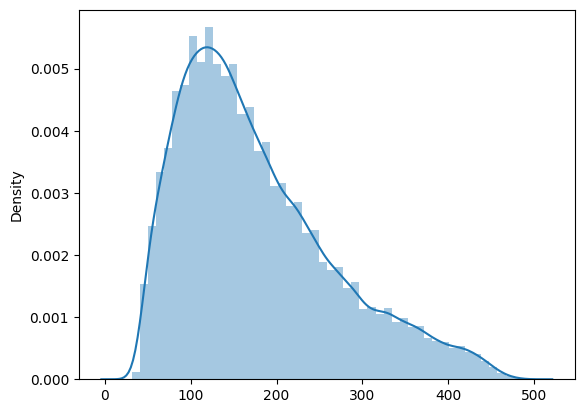

In [118]:
sns.distplot(np.array(len_list))
plt.show()

In [119]:
insert_docs = index_mrc_docs(idx='news_mrc', docs=docs, title='doc_title', doc_id='doc_id')
print(len(insert_docs))

125964


In [120]:
insert_docs[0]

{'doc_id': '01601101.20210325201932006',
 '_index': 'news_mrc',
 'source': 'news_mrc_train',
 'title': '익산 서부권역 다목적 체육관, 다음달 개관',
 'context': '익산시 서부권역 다목적 체육관이 내달 개관을 앞두고 막바지 개관 준비가 한창이다. \n\n시에 따르면 시민들의 건강증진과 삶의 질 향상을 위한 생활체육 인프라 확충 등을 위해 지난 2019년 착공된 서부권역 다목적 체육관이 이달 말까지 시설물 준공을 완료하고 다음달부터 본격적인 개관 운영에 들어간다. \n\n전문 체육시설인 서부권역 다목적 체육관은 지하 1층과 지상 3층, 연면적 4719㎡ 규모로 총 사업비 124억5000만원이 투입됐다. \n\n수영장 6개 레인과 어린이풀장, 다목적실(에어로빅, 요가 등), 체력단련실, 어르신들을 위한 물리ㆍ재활 운동실 등이 들어서며, 수영, 헬스, 요가, 에어로빅, 아쿠아로빅 등 총 5가지 프로그램이 운영될 예정이다. \n\n첫 번째로 개관되는 시설은 헬스장이다. \n\n다음달 중순부터 회원 신청이 가능하며 체육관에 방문해 신청하면 된다. \n\n아울러 시는 코로나19 예방을 위해 소독작업은 물론 체육관 운영시간과 참여 인원을 축소해 운영하는 방안을 계획하고 있다. \n\n체육관 전체 소독은 하루 3회로 먼저 개관되는 헬스장의 경우 오후 1시부터 2시까지 1시간 동안 브레이크타임을 도입해 기구와 라커룸 등의 소독작업을 실시한다. \n\n시 관계자는 “시민들이 쾌적한 환경에서 다양한 체육활동에 참여할 수 있도록 시설 확충에 주력하고 있다”며“앞으로도 시민들의 생활체육활동을 지원할 수 있는 인프라를 지속적으로 확충해 나 가겠다”고 말했다.',
 'qas': [{'qa_type': 1,
   'question_id': 4559297,
   'question': '익산시에서 시민들의 건강을 위해 운영을 준비 중인 시설은 뭐야',
   'is_impossible': False,
 

In [121]:
helpers.bulk(es, insert_docs)

(125964, [])

## book_mrc

In [122]:
aihub_list = glob.glob("./aihub/book_mrc/*.json")

In [123]:
aihub_list

['./aihub/book_mrc/book_dev.json', './aihub/book_mrc/book_train.json']

In [124]:
docs = load_dataset(aihub_list)

In [125]:
print("** mean **")
data_list = [docs['train']['data'], docs['dev']['data']]
show_doc_len(data_list, np.mean)
print("** median **")
show_doc_len(data_list, np.median)
print("** max **")
show_doc_len(data_list, max)

** mean **
111.38915797317436
112.23570712136409
** median **
110.0
112.0
** max **
170
171


In [126]:
res = check_ctx_len(docs['train']['data']+docs['dev']['data'])# 최대 최소 등 길이 정보를 조회하는 목적
len_list = [l["len_ctxs"] for l in res]

num = 0

for l in len_list:
    if l > 150:
        num += 1

print(num/len(len_list))

0.02023906547133931


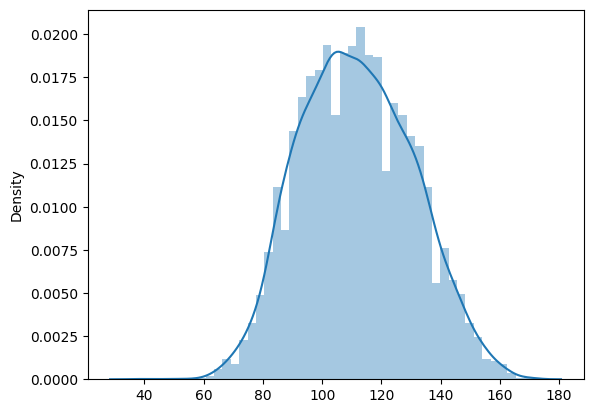

In [127]:
sns.distplot(np.array(len_list))
plt.show()

최대 길이 171. 아주 긴 단락은 없음

In [128]:
docs['train']['data'][0].keys()

dict_keys(['time', 'title', 'agency', 'year', 'content_id', 'KDC', 'paragraphs'])

In [129]:
insert_docs = index_mrc_docs(idx='book_mrc', docs=docs, title='title', doc_id='content_id')
print(len(insert_docs))

237500


In [130]:
helpers.bulk(es, insert_docs)

(237500, [])

## minds_news_mrc

In [131]:
aihub_list = glob.glob("./aihub/mindslab_news_mrc/*.json")

In [132]:
aihub_list

['./aihub/mindslab_news_mrc/ko_nia_noanswer_squad_all.json',
 './aihub/mindslab_news_mrc/ko_nia_clue0529_squad_all.json',
 './aihub/mindslab_news_mrc/ko_nia_normal_squad_all.json']

In [133]:
docs = load_dataset(aihub_list)

In [134]:
docs['dev']["data"][40001].keys()

dict_keys(['title', 'paragraphs', 'source'])

In [135]:
print("** mean **")
show_doc_len([docs['dev']['data']], np.mean)
print("** median **")
show_doc_len([docs['dev']['data']], np.median)
print("** max **")
show_doc_len([docs['dev']['data']], max)

** mean **
196.71443970072283
** median **
180.0
** max **
1481


In [136]:
res = check_ctx_len(docs['dev']['data'])# 최대 최소 등 길이 정보를 조회하는 목적
len_list = [l["len_ctxs"] for l in res]

num = 0

for l in len_list:
    if l > 400:
        num += 1

print(num/len(len_list))

0.040178382719702414


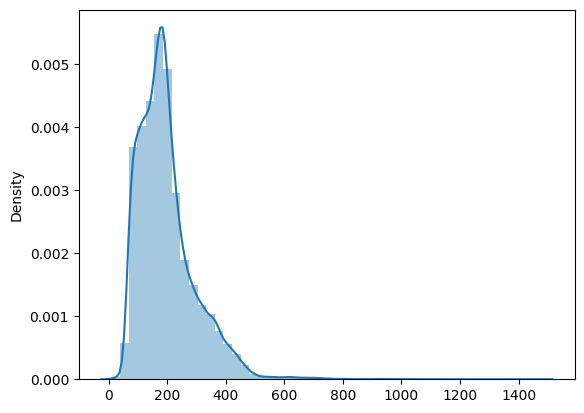

In [137]:
sns.distplot(np.array(len_list))
plt.show()

In [138]:
insert_docs = index_mrc_docs(idx='minds_news_mrc', docs=docs, title='title', doc_id=False)
print(len(insert_docs))

47314


In [139]:
helpers.bulk(es, insert_docs)

(47314, [])

In [140]:
insert_docs[0]

{'_index': 'minds_news_mrc',
 'source': 'minds_news_mrc_dev',
 'title': '15657',
 'context': "한국청소년단체협의회와 여성가족부는 22일부터 28일까지 서울과 충북 괴산에서 '국제청소년포럼'을 연다고 21일 밝혔다. 한국 미국 캐나다 호주 등 전 세계 32개국 75여명의 대학생, 청소년들이 모여 전 세계적 현안문제에 대한 대안과 해결책을 모색하는 자리다. 이번 포럼의 주제는 '청소년과 뉴미디어'다. 스마트폰 SNS 태블릿PC 등 새로운 커뮤니케이션 매체인 '뉴미디어'에 대한 성찰과 문제점에 대해 토론한다. 기조강연을 시작으로 국가별 주제관련 사례발표, 그룹 토론 및 전체총회, '청소년선언문' 작성 및 채택 등 다양한 프로그램을 운영한다. 개회식은 22일 서울 방화동에 있는 국제청소년센터 국제회의장에서 한다. 전 세계 32개국 대학생ㆍ청소년 참가자와 전국의 청소년기관단체장과 청소년지도자 여성가족부 주한외교사절 등 100여명이 참석할 예정이다. 23일에는 유엔미래포럼 박영숙 대표가 '뉴미디어의 균형 있는 발전을 위한 청소년의 역할'에 대해 기조강연을 한다. 뉴미디어의 올바른 활용방안과 청소년문화의 형성에 대해 설명할 계획이다. 27일 폐회식에서는 '청소년선언문'을 채택한다. 선언문에는 전 세계적으로 뉴미디어의 바람직한 발전을 촉구하며 각국 청년들이 함께 실천할 수 있는 내용 등이 담길 예정이다. 한국청소년단체협의회는 포럼이 끝난 뒤 UN 등 국제기구와 참가자 각국 정부 등 국제사회에 선언문을 전달할 예정이다.",
 'qas': [{'question': "서울과 충북 괴산에서 '국제청소년포럼'을 여는 곳은?",
   'answers': [{'answer_start': 0, 'text': '한국청소년단체협의회와 여성가족부'}],
   'id': 'c1_57059-1',
   'classtype': 'work_who'},
  {'question': "'국제 청소년포럼'이 열리는 때는?",
   'a

In [141]:
print( 75917 + 125964 + 237500 + 47314 )

486695


# 간단 요약 노트

총 단락 수는 486,695.  
  
단락 별 길이가 대략 100 언저리(110~190).  
최대길이는 1,481(Mindslab이 구축한 뉴스 MRC 데이터)  
긴 단락들은 보통 300~500  

---  

#### 긴 단락 처리 잔략

**처리 안했을 때랑 했을 때 결과 차이 비교를 해야함**

1. 100으로 자른다고 했을 때, 남은 단어가 너무 짧은 경우(10 단어 이하) 버림.
2. 잘라내서 정답이 영역이 삭제된 경우는 체크 필요.
3. 영억이 사라지지 않은 경우, offset 변화량은 체크해야함.  

분리되서 추가된 단락인 경우 원래 전체 단락 형태, 그 단락에서 원래 offset 정보를 가지고 있어야함. parent_id, origin_start_offset 기억해서 더해주면 될 것.
  
#### positive, negative ctxs들 처리 방법
  
* 검색 영역: title, ctxs
* 검색 쿼리: 정답 영역 단어들 + question 
* 오답 정의: 답이 passage 안에 없음
  
1. 정답 걸려 나온 경우 -> pos_ctxs 리스트 포함( 최대 100개? )
2. 오답들 -> score가 0인 것들(타 단락에서 정답인 것으로 in batch 한다면 내가 고려할 건 없는 게 아닌지?)
3. hard negative -> score가 0이 아닌데 오답임 == answer 는 match 안되고 question만 match 됨.

In [181]:
def split_passage(passage: str, max_len: int =120, min_len: int = 10):
    # whitespace 기준으로 길이 측정
    #tokens = passage.split(" ")
    tokens = passage
    sub_passg = []
    for i in range(0, len(tokens), max_len):
        sub_passg.append(tokens[i:i+max_len])
    return sub_passg

In [182]:
passage = list(range(0, 140))
res = split_passage(passage, 3)


In [184]:
res[0:4]

[[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11]]

In [185]:
ll = [0,1,2]
ll[:-1]

[0, 1]

In [192]:
10 in range(*(0,10))

False

In [210]:
EXPLAIN = True
DEFAULT = "default"
GROUP_TOPK = 1
TOPK = 100
OPERATOR = "or"
Q_WEIGHTS = 2
A_WEIGHTS = 1
TAG_WEIGHTS = 1


QUERY = {
    "all": {
        "query": {
            "match_all": {}
        }
    },
    "nori": {
        "query": {
            "multi_match": {
                "query": DEFAULT,
                "operator": OPERATOR,
                "fields": [f"question.nori^{Q_WEIGHTS}", f"answer.nori^{A_WEIGHTS}",
                           f"word.nori^{Q_WEIGHTS}", f"tags.ngram_token^{TAG_WEIGHTS}"]
            }
        },
        "size": TOPK,
        "explain": EXPLAIN
    },
    "ngram": {
        "query": {
            "multi_match": {
                "query": DEFAULT,
                "operator": OPERATOR,
                "fields": [f"question.ngram^{Q_WEIGHTS}", f"answer.ngram^{A_WEIGHTS}",
                           f"word.ngram^{Q_WEIGHTS}", f"tags.ngram_token^{TAG_WEIGHTS}"]
            }
        },
        "size": TOPK,
        "explain": EXPLAIN
    },
    "keyword": {
        "query": {
            "multi_match": {
                "query": DEFAULT,
                "operator": OPERATOR,
                "fields": ["answer.keyword", "question.keyword", "tags.keyword", "word.keyword"]
            }
        },
        "size": TOPK,
        "explain": EXPLAIN
    },
    "sort":{
        "_score" : {"order":"desc"}
    },
    "aggs": {
        "by_ids": {
          "terms": {
            "field": "{pivot_id}.keyword",
            "size": TOPK,
            "order": {"max_score": "desc"}
          },
          "aggs": {
            "by_top_hit": {"top_hits": {"size": GROUP_TOPK}},
            "max_score": {"max": {"script": "_score"}}
          }
        }
    },
    "multi_queris": {
        "query": {
            "bool": {
                "should": [

                ]
            }
        },
        "size": TOPK,
        "explain": EXPLAIN
    },
    "positive":{
        "query": {
            "bool": {
                "must":[
                    {
                        "wildcard": {
                            "context.keyword": "*{query}*"
                        }
                    },
                    {
                        "multi_match": {
                            "query":  DEFAULT,
                            "operator": "or",
                            "fields": ["title.nori","title.ngram","context.nori"]
                        }
                    }
                ]
            }
        },
        "size": TOPK,
        "explain": EXPLAIN
    },
    "hard_negative": {
        "query": {
            "bool": {
                "must_not":[
                    {
                        "wildcard": {
                            "context.keyword": "*{query}*"
                        }
                    }
                ],
                "should": [
                    {
                        "multi_match": {
                            "query": DEFAULT,
                            "operator": "or",
                            "fields": ["title.nori","title.ngram","context.nori"]
                        }
                    }
                    
                ]
            }
        },
        "size": TOPK,
        "explain":EXPLAIN
    }
}



In [212]:
query = copy.copy(QUERY['positive'])

In [220]:
answ = "국청소년단체협의회와 여성가족부"
question = "서울과 충북 괴산에서 '국제청소년포럼'을 여는 곳은?"

new_q = query["query"]["bool"]["must"][0]["wildcard"]["context.keyword"].format(query=answ)

query["query"]["bool"]["must"][0]["wildcard"]["context.keyword"] = new_q
query["query"]["bool"]["must"][1]["multi_match"]["query"]=question

In [221]:
query

{'query': {'bool': {'must': [{'wildcard': {'context.keyword': '*국청소년단체협의회와 여성가족부*'}},
    {'multi_match': {'query': "서울과 충북 괴산에서 '국제청소년포럼'을 여는 곳은?",
      'operator': 'or',
      'fields': ['title.nori', 'title.ngram', 'context.nori']}}]}},
 'size': 100,
 'explain': True}

In [207]:
res = es.search(index=index, body=QUERY['all'])

In [208]:
len(res['hits']['hits'])

10

In [205]:
res['hits']['hits'][0]["_source"].keys()

dict_keys(['source', 'title', 'qas', 'context'])